<a href="https://colab.research.google.com/github/TheAllBlueChevy/UST-Deep-Learning-2026/blob/main/HWK6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HWK6**

# 0) Importing Libraries and Data Upload

In [7]:
import os, imageio, warnings
warnings.filterwarnings('ignore')  # Suppress Warnings for Cleaner Output

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from IPython.display import Image, display

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA  # For 2D visualization if Latent > 2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback

from google.colab import files  # Upload Data in Colab

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
# Upload CSV file Containing Single-Cell Gene Expression Data
uploaded = files.upload()

# Read CSV to Pandas DataFrame
df = pd.read_csv('single_cell.csv')

Saving single_cell.csv to single_cell (1).csv


# 1) Preprocessing the Data

In [9]:
# Extract Features (Except Group & Index)
X = df.drop(columns=['group', 'Unnamed: 0'])

# Extract Labels (Group Column)
y = df['group']

# Convert Data to Numeric, Replace Missing Values with NaN
X = X.replace('NA', np.nan).astype(float)

# Replace Missing Values with Median
X = X.fillna(X.median())

# Log-Transform to Reduce Skew, Standardize Features (mean=0, std=1)
X_scaled = StandardScaler().fit_transform(np.log1p(X))

# Encode Group Labels to Integers (0,1,2,...)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Store Group Labels for Legend
y_labels = le.classes_

print(f"Preprocessed features shape: {X_scaled.shape}")
print(f"Groups/classes: {y_labels}")

Preprocessed features shape: (100, 199)
Groups/classes: ['Group1' 'Group2' 'Group3' 'Group4']


# 2) Define FCN Classifier

In [10]:
# Define Input Dimension & Latent Embedding Size
input_dim = X_scaled.shape[1]
latent_dim = 64  # Size of "Latent" Layer

# Functional API Flexible Layer Connections & Easy Latent Extraction
inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(inputs)
x = layers.Dropout(0.2)(x)
latent = layers.Dense(latent_dim, activation='relu', name='latent')(x)
x = layers.Dropout(0.2)(latent)
outputs = layers.Dense(len(y_labels), activation='softmax')(x)

# Create Model
classifier = keras.Model(inputs=inputs, outputs=outputs, name='classifier')

# Compile Model with Optimizer, Loss, & Eval Metric
classifier.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Integer Labels
    metrics=['accuracy']
)

classifier.summary()

Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 199)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,116 (133.27 KB)

 Trainable params: 34,116 (133.27 KB)

 Non-trainable params: 0 (0.00 B)

# 3) Embedding

In [11]:
# Keras Callback Captures Latent Embeddings after Each Batch
class EmbeddingBatchCallback(Callback):
    def __init__(self, model, data):
        super().__init__()
        self.model_ref = model          # References Classifier Model
        self.data = data                # Gets Embeddings for
        self.embeddings = []            # Store Embeddings

        # Separate Model for Latent Layer Output
        self.latent_model = keras.Model(
            inputs=model.input,
            outputs=model.get_layer('latent').output
        )

    # Called at End of Each Trainign Batch
    def on_train_batch_end(self, batch, logs=None):
        emb = self.latent_model.predict(self.data, verbose=0)  # Get Latent Embedding
        self.embeddings.append(emb)     # Store

# Initiate Callback
embedding_cb = EmbeddingBatchCallback(classifier, X_scaled)

# 4) Training Classifier

In [12]:
# Train Classifier, Capture Batch Embeddings
history = classifier.fit(
    X_scaled,
    y_encoded,
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[embedding_cb]
)

print(f"Total embeddings captured: {len(embedding_cb.embeddings)}")

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - accuracy: 0.2285 - loss: 1.5839 - val_accuracy: 0.7000 - val_loss: 0.9848
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7203 - loss: 0.7748 - val_accuracy: 0.8500 - val_loss: 0.5659
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9401 - loss: 0.4398 - val_accuracy: 0.9500 - val_loss: 0.3303
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9639 - loss: 0.2743 - val_accuracy: 1.0000 - val_loss: 0.2055
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9891 - loss: 0.1507 - val_accuracy: 1.0000 - val_loss: 0.1371
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0752 - val_accuracy: 1.0000 - val_loss: 0.1028
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 0.0472 - val_accuracy: 1.0000 - val_loss: 0.0819
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 1.0000 - loss: 0.0639 - val_accuracy: 1.0000 - val_loss: 0.

# 5) Gif Plotting

GIF saved: latent_evolution.gif


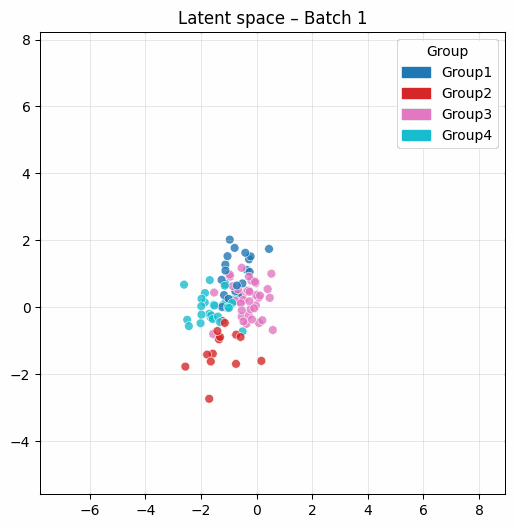

In [13]:
# Store Image Frame Directory
os.makedirs('emb_frames', exist_ok=True)
image_paths = []

# Stack Embeddings Determining Axis Limits
all_emb = np.vstack(embedding_cb.embeddings)

# If latent_dim > 2, reduce to 2D using PCA for plotting
if latent_dim > 2:
    pca = PCA(n_components=2)
    all_emb_2d = pca.fit_transform(all_emb)
else:
    all_emb_2d = all_emb

x_limits = (all_emb_2d[:,0].min()-0.5, all_emb_2d[:,0].max()+0.5)
y_limits = (all_emb_2d[:,1].min()-0.5, all_emb_2d[:,1].max()+0.5)

# Generate Frame per Batch
for batch_idx, emb in enumerate(embedding_cb.embeddings):
    # Reduce to 2D if necessary
    if latent_dim > 2:
        emb_2d = pca.transform(emb)
    else:
        emb_2d = emb

    plt.figure(figsize=(6,6))
    # Scatter Plot of Latent Embeddings by Group
    plt.scatter(
        emb_2d[:,0], emb_2d[:,1],
        c=y_encoded,
        cmap='tab10',
        s=40,
        alpha=0.8,
        edgecolor='w',
        linewidth=0.5
    )

    plt.xlim(x_limits)
    plt.ylim(y_limits)
    plt.grid(alpha=0.3)

    # Legend Mapping by Groups
    cmap = cm.get_cmap('tab10', len(y_labels))
    handles = [mpatches.Patch(color=cmap(i), label=y_labels[i]) for i in range(len(y_labels))]
    plt.legend(handles=handles, title='Group', loc='best')

    plt.title(f'Latent space – Batch {batch_idx + 1}')

    # Save Frame
    path = f'emb_frames/batch_{batch_idx + 1:03d}.png'
    plt.savefig(path, dpi=100, bbox_inches='tight')
    plt.close()
    image_paths.append(path)

# Compile Frames to GIF
gif_path = 'latent_evolution.gif'
with imageio.get_writer(gif_path, mode='I', duration=0.3, loop=0) as writer:
    for path in image_paths:
        writer.append_data(imageio.imread(path))

print(f"GIF saved: {gif_path}")
display(Image(filename=gif_path))
